This notebook provides an example to run the hybrid mini-grid optimization for a single settlement.
Hourly PV and temperature data are retrieved from renewables.ninja, and the hourly loads are estimated based on annual demand and example load curve shapes for each Tier of the Multi-Tier Franework. Both can be replaced if better data is available.

# Import neccessary packages

In [1]:
from hybrids import *
#from src.mgoptimization.pso import *
import os
#import pulp
from scipy.optimize import Bounds, differential_evolution
import time

# Location of settlement

In [2]:
long = -3
lat = 24

# Retrieve solar resource data for the location

Select where to save the PV data

In [3]:
pv_data_folder = 'Input_Data/pv'

Enter your renewables.ninja token

In [4]:
token = ''

This cell retrieves the PV data from renewables.ninja using your token

In [5]:
get_pv_data(lat, long, token, pv_data_folder)

No token provided


In [6]:
hourly_ghi, hourly_temp = read_environmental_data(os.path.join(pv_data_folder, 'pv_data_lat_{}_long_{}.csv'.format(lat, long)))

# Calculate hourly load curve

The below cells estimates the load (kWh) for each hour in the year based on the annual demand, and example load curve shapes for each Tier of the Multi-Tier Framework. If the hourly load curve is already known for the settlement, replace the load_curve variable with that load curve.

In [7]:
demand = 365*361 # Total annual demand (kWh) in location
tier = 2  # Average Tier of the Multi-Tier Framework in the location.

In [8]:
load_curve = calc_load_curve(tier, demand)

# Run the optimization to find the best combination of PV, diesel and batteries, as well as the corresponding LCOE

Update the costs and other techno-economic variables below

In [9]:
def optimizer_de(diesel_price,
              hourly_ghi,
              hourly_temp,
              load_curve,
              diesel_cost=261,  # diesel generator capital cost, USD/kW rated power
              discount_rate=0.08,
              n_chg=0.93,  # charge efficiency of battery
              n_dis=1,  # discharge efficiency of battery
              battery_cost=314,  # battery capital cost, USD/kWh of storage capacity
              pv_cost=660,  # PV panel capital cost, USD/kW peak power
              charge_controller=142,  # PV charge controller cost, USD/kW peak power, set to 0 if already included in pv_cost
              pv_inverter=80,  # PV inverter cost, USD/kW peak power, set to 0 if already included in pv_cost
              pv_life=25,  # PV panel expected lifetime, years
              diesel_life=10,  # diesel generator expected lifetime, years
              pv_om=0.015,  # annual OM cost of PV panels
              diesel_om=0.1,  # annual OM cost of diesel generator
              battery_inverter_cost=539,
              battery_inverter_life=20,
              dod_max=0.8,  # maximum depth of discharge of battery
              inv_eff=0.93,  # inverter_efficiency
              lpsp_max=0.02,  # maximum loss of load allowed over the year, in share of kWh
              diesel_limit=0.5,
              full_life_cycles=2500,
              start_year=2020,
              end_year=2030,
              ):

    demand = load_curve.sum()

    # The following lines defines the solution space for the Particle Swarm Optimization (PSO) algorithm
    battery_bounds = [0, 5 * demand / 365]
    pv_bounds = [0, 5 * max(load_curve)]
    diesel_bounds = [0.5, max(load_curve)]
    
    min_bounds = np.array([pv_bounds[0], battery_bounds[0], diesel_bounds[0]])
    max_bounds = np.array([pv_bounds[1], battery_bounds[1], diesel_bounds[1]])
    bounds = Bounds(min_bounds, max_bounds)

    #print(zip(min_bounds, max_bounds))
    #  This creates a series of the hour numbers (0-24) for one year
    hour_numbers = np.empty(8760)
    for i in prange(365):
        for j in prange(24):
            hour_numbers[i * 24 + j] = j

    def opt_func(X):
        lcoe = find_least_cost_option(X, hourly_temp, hourly_ghi, hour_numbers,
                                       load_curve, inv_eff, n_dis, n_chg, dod_max,
                                       diesel_price, end_year, start_year, pv_cost, charge_controller, pv_inverter, pv_om,
                                       diesel_cost, diesel_om, battery_inverter_life, battery_inverter_cost, diesel_life, pv_life,
                                       battery_cost, discount_rate, lpsp_max, diesel_limit, full_life_cycles)[0]
                                       
        return lcoe

    minimizer_kwargs = {"method": "BFGS"}
    pv_init = sum(pv_bounds)/2
    battery_init = sum(battery_bounds)/2
    diesel_init = sum(diesel_bounds)/2
    x0 = [pv_init, battery_init, diesel_init]
    
    #return differential_(opt_func, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
    return differential_evolution(opt_func, bounds, popsize=15, init='latinhypercube') # init='halton' on newer env


In [10]:
# Define variables

start_year=2024
end_year=2039
diesel_price=0.5 # USD/liter of diesel fuel
discount_rate=0.08
diesel_cost=378  # diesel generator capital cost, USD/kW rated power
battery_cost=589  # battery capital capital cost, USD/kWh of storage capacity
full_life_cycles=2000 # full battery cycles before failure
battery_inverter_cost=608  # USD/kW
pv_cost=1147  # PV panel capital cost, USD/kW peak power
pv_inverter=0 # PV inverter cost, USD/kW peak power, set to 0 if already included in pv_cost
charge_controller=0 # PV charge controller cost, USD/kW peak power, set to 0 if already included in pv_cost
diesel_limit=0.5 # Maximum share of generation over a year coming from diesel generator
lpsp_max=0.005
inv_eff=0.93
n_chg=0.93  # charge efficiency of battery
n_dis=1  # discharge efficiency of battery
dod_max=0.8  # maximum depth of discharge of battery
pv_om=0.015  # annual OM cost of PV panels
diesel_om=0.1  # annual OM cost of diesel generator
battery_inverter_life=20
pv_life=25  # PV panel expected lifetime, years
diesel_life=10  # diesel generator expected lifetime, years

In [11]:
# The below runs the optimization for the location, and tries to identify the best combination of PV, Diesel & Battery
# using scipy minimization (differential evolution). This is run 5 times just for testing purposes
for i in range(5):
    t1 = time.time()
    ret = optimizer_de(diesel_price=diesel_price, 
                   hourly_ghi=hourly_ghi,
                   hourly_temp=hourly_temp,
                   load_curve=load_curve,
                   start_year=start_year,
                   end_year=end_year,
                   discount_rate=discount_rate,
                   diesel_cost=diesel_cost,  
                   battery_cost=battery_cost,  
                   full_life_cycles=full_life_cycles, 
                   battery_inverter_cost=battery_inverter_cost,  
                   pv_cost=pv_cost,  
                   pv_inverter=pv_inverter, 
                   charge_controller=charge_controller, 
                   diesel_limit=diesel_limit, 
                   lpsp_max=lpsp_max,
                   inv_eff=inv_eff,
                   n_chg=n_chg,
                   n_dis=n_dis,
                   dod_max=dod_max,
                   pv_om=pv_om,
                   diesel_om=diesel_om,
                   battery_inverter_life=battery_inverter_life,
                   pv_life=pv_life,
                   diesel_life=diesel_life)  
    t2 = time.time()

    print('Best LCOE: {} USD/kWh'.format(round(ret.fun, 3)))
    print('Best PV capacity: {} kW'.format(round(ret.x[0], 1)))
    print('Best Battery capacity: {} kWh'.format(round(ret.x[1], 1)))
    print('Best Diesel capacity: {} kWh'.format(round(ret.x[2], 1)))
    print('Optimization time: {} s'.format(round(t2-t1, 2)))
    print('')

Best LCOE: 0.265 USD/kWh
Best PV capacity: 37.3 kW
Best Battery capacity: 84.9 kWh
Best Diesel capacity: 23.7 kWh
Optimization time: 2.51 s

Best LCOE: 0.274 USD/kWh
Best PV capacity: 37.8 kW
Best Battery capacity: 75.4 kWh
Best Diesel capacity: 24.1 kWh
Optimization time: 0.54 s

Best LCOE: 0.265 USD/kWh
Best PV capacity: 37.3 kW
Best Battery capacity: 85.0 kWh
Best Diesel capacity: 23.7 kWh
Optimization time: 2.94 s

Best LCOE: 0.265 USD/kWh
Best PV capacity: 37.2 kW
Best Battery capacity: 84.8 kWh
Best Diesel capacity: 23.7 kWh
Optimization time: 3.54 s

Best LCOE: 0.265 USD/kWh
Best PV capacity: 37.2 kW
Best Battery capacity: 85.1 kWh
Best Diesel capacity: 23.8 kWh
Optimization time: 4.03 s



# Run optimal solution and visualize the results for two example days

In [12]:
import matplotlib.pyplot as plt
import numpy as np

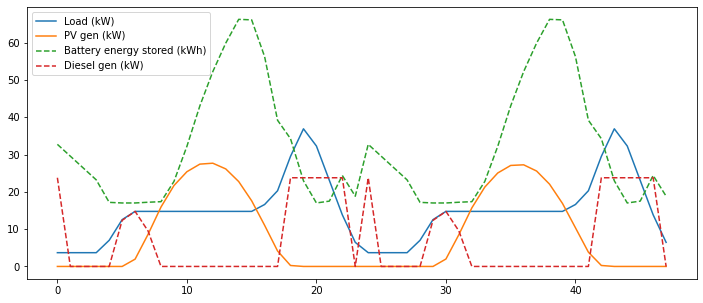

In [13]:
hour_numbers = np.empty(8760)
for i in prange(365):
    for j in prange(24):
        hour_numbers[i * 24 + j] = j
        
pv = ret.x[0]
battery = ret.x[1]
diesel = ret.x[2]

net_load, pv_gen = pv_generation(hourly_temp, hourly_ghi, pv, load_curve, inv_eff)

diesel_generation_share, battery_life, unmet_demand_share, annual_fuel_consumption, \
        excess_gen_share, battery_soc_curve, diesel_gen_curve = \
        year_simulation(battery_size=battery, diesel_capacity=diesel, net_load=net_load, hour_numbers=hour_numbers,
                        inv_eff=inv_eff, n_dis=n_dis, n_chg=n_chg, dod_max=dod_max,
                        annual_demand=demand, full_life_cycles=full_life_cycles)

battery_soc_curve = [i * dod_max + (1 - dod_max) for i in battery_soc_curve]
battery_usage = battery * np.array(battery_soc_curve[2400:2448])

plt.figure(figsize=(12, 5))
plt.plot(load_curve[2400:2448], label='Load (kW)')
plt.plot(pv_gen[2400:2448], label='PV gen (kW)')
plt.plot(battery_usage, '--', label='Battery energy stored (kWh)')
plt.plot(diesel_gen_curve[2400:2448], '--', label='Diesel gen (kW)')
plt.legend(loc='upper left')